In [1]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import os
import albumentations
from albumentations.pytorch.transforms import ToTensor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
try:
    %config InlineBackend.figure_format = 'retina'
    plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
except:
    pass

In [2]:
EPOCH = 500
#set to 1000 for composition7, 10000 for starry night
alpha = 1000
img_x = 768
img_y = int(3*img_x/4)
device = 'cuda'
content_reference = 'heidelberg.jpg'
style_reference = 'composition7.jpg'

In [3]:
C_orig = plt.imread(content_reference)
S_orig = plt.imread(style_reference)

In [4]:
transform = albumentations.Compose([
    albumentations.Resize(img_y,img_x,always_apply=True),
    albumentations.Normalize(always_apply=True),
    ToTensor()
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [5]:
def gram_matrix(filter):
    batch_size, nc, h, w = filter.shape
    g = filter.view(batch_size*nc, h*w)
    gram = torch.mm(g, g.t())
    return gram

In [6]:
def save_image(G, epoch):
    image = unorm(G.squeeze())
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    image = np.clip(image, 0, 1)
    plt.imsave(f'generated/generated_{epoch}.jpg', image)
    pass

In [7]:
C = transform(image=C_orig)['image'].unsqueeze(0).to(device)
S = transform(image=S_orig)['image'].unsqueeze(0).to(device)
model = models.vgg16(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
G = torch.tensor(C.cpu().numpy(), requires_grad=True, device=device)
optimizer = torch.optim.LBFGS([G])

In [8]:
losses = {'content':[], 'style': [], 'total':[]}

In [9]:
model_layers = [
    (1,8),
    (8,15),
    (15,22),
    (22,29)
]

In [10]:
pbar = tqdm(total=EPOCH)

epoch=0
while epoch<=EPOCH:

    #function for LBFGS optimizer to call
    def closure():
        global epoch

        #compute content loss
        content_G = model.features[:20](G)
        content_C = model.features[:20](C)
        loss_content = F.mse_loss(content_G, content_C)
        
        #get intermediate representations for style loss
        layers_G = [model.features[0](G)]
        layers_S = [model.features[0](S)]
        for idx in model_layers:
            layers_G.append(model.features[idx[0]:idx[1]](layers_G[-1]))
            layers_S.append(model.features[idx[0]:idx[1]](layers_S[-1]))

        #compute style loss using gram matrix
        style_losses = []
        for g, s in zip(layers_G, layers_S):
            num_channels = g.shape[1]
            num_pixels = g.shape[2]
            factor = 4*num_channels*num_channels*num_pixels*num_pixels
            style_losses.append(F.mse_loss(gram_matrix(g), gram_matrix(s))/factor)

        loss_style = sum(style_losses)/len(style_losses)  #equal weights for each layer

        #total loss
        loss = loss_content + alpha*loss_style

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #log metrics
        losses['content'].append(loss_content.item())
        losses['style'].append(alpha*loss_style.item())
        losses['total'].append(loss.item())
        if (epoch+1)%50==0:
            tqdm.write(f'Epoch: {epoch}, Content Loss: {loss_content.item()}, Style Loss: {loss_style.item()}, Loss: {loss.item()}\n')
            save_image(G.cpu().detach(), epoch)
        pbar.update()
        epoch+=1

        return loss

    optimizer.step(closure)
    
pbar.close()

Epoch: 49, Content Loss: 39.47065353393555, Style Loss: 0.08836545795202255, Loss: 127.83610534667969

Epoch: 99, Content Loss: 29.25897979736328, Style Loss: 0.03255460783839226, Loss: 61.8135871887207

Epoch: 149, Content Loss: 23.554365158081055, Style Loss: 0.018975842744112015, Loss: 42.530208587646484

Epoch: 199, Content Loss: 20.43074607849121, Style Loss: 0.013520521111786366, Loss: 33.95126724243164

Epoch: 249, Content Loss: 18.435436248779297, Style Loss: 0.010752192698419094, Loss: 29.18762969970703

Epoch: 299, Content Loss: 16.903329849243164, Style Loss: 0.00879675429314375, Loss: 25.700084686279297

Epoch: 349, Content Loss: 15.760053634643555, Style Loss: 0.007371635176241398, Loss: 23.131689071655273

Epoch: 399, Content Loss: 14.831457138061523, Style Loss: 0.006336827762424946, Loss: 21.168285369873047

Epoch: 449, Content Loss: 14.076849937438965, Style Loss: 0.005540180020034313, Loss: 19.61703109741211

Epoch: 499, Content Loss: 13.493048667907715, Style Loss: 0

Text(0, 0.5, 'Loss')

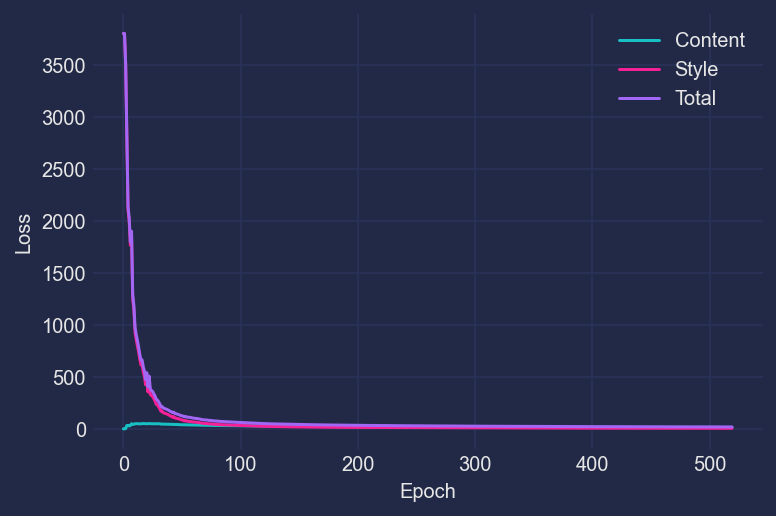

In [12]:
sns.lineplot(x=list(range(len(losses['content']))), y=losses['content'])
sns.lineplot(x=list(range(len(losses['style']))), y=losses['style'])
sns.lineplot(x=list(range(len(losses['total']))), y=losses['total'])
plt.legend(['Content','Style','Total'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1000)